# Example of using Re-Project package to homogeneize Instrument viewpoint

The most strict combination of our HR data and HMI would require a perfect spatial mapping between instruments, which is beyond the scope of our project.  However, a reasonable match between them can be achieved using the re-project package.  This notebook shows an example of this. 

### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Extend the size of the Window

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [28]:
import numpy as np
from astropy.io import fits
import matplotlib.pylab as plt
import pandas as pd
from sunpy.map import Map
import astropy.units as u
from reproject import reproject_exact, reproject_interp #use reproject_interp if you want it done quicker.

### Define colors an colormaps

In [4]:
# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

---

## Specify paths and load index match file

In [5]:
source = 'MDI'
hr_path = '/scratch/' + source.lower() + '/HR/'
hmi_path = '/scratch/hmi/raw_sub/'

## Load matching CSV

In [6]:
hr_hmi_set = pd.read_csv(hr_path + source.lower() + '-hmi-match.csv')
hr_hmi_set.head()

dateobs_hr                                        filepath_hr  \
0  2011-01-01 00:00:26  /2011/01/01/mdi.fd_M_96m_lev182.20110101_00000...   
1  2011-01-01 01:36:26  /2011/01/01/mdi.fd_M_96m_lev182.20110101_01360...   
2  2011-01-01 03:12:26  /2011/01/01/mdi.fd_M_96m_lev182.20110101_03120...   
3  2011-01-01 04:48:26  /2011/01/01/mdi.fd_M_96m_lev182.20110101_04480...   
4  2011-01-01 06:24:26  /2011/01/01/mdi.fd_M_96m_lev182.20110101_06240...   

                  dateobs_hmi  \
0  2010-12-31 23:58:10.200000   
1  2011-01-01 01:34:10.200000   
2  2011-01-01 03:10:10.200000   
3  2011-01-01 04:46:10.300000   
4  2011-01-01 06:22:10.300000   

                                        filepath_hmi               timedelta  
0  /2011/01/01/hmi.M_720s.20110101_000000_TAI.1.m...  0 days 00:02:15.800000  
1  /2011/01/01/hmi.M_720s.20110101_013600_TAI.1.m...  0 days 00:02:15.800000  
2  /2011/01/01/hmi.M_720s.20110101_031200_TAI.1.m...  0 days 00:02:15.800000  
3  /2011/01/01/hmi.M_720s.20110101_044800_TAI.1.m...  0 days 00:02:15.700000  
4  /2011/01/01/hmi.M_720s.20110101_062400_TAI.1.m...  0 days 00:02:15.700000

## Chose a month to focus on

In [7]:
target_month = 3

# Mask entries in the hr instrument of the desired month
mask = pd.to_datetime(hr_hmi_set['dateobs_hr'], format='%Y-%m-%d %H:%M:%S').map(lambda x: x.month)==target_month
# Make sure the closest target magnetograms are also in that month
mask = np.logical_and(pd.to_datetime(hr_hmi_set['dateobs_hmi'], format='%Y-%m-%d %H:%M:%S').map(lambda x: x.month)==target_month, mask)

# Apply mask
hr_hmi_set = hr_hmi_set.loc[mask, :].reset_index(drop=True)
hr_hmi_set

dateobs_hr                                        filepath_hr  \
0    2011-03-01 01:36:26  /2011/03/01/mdi.fd_M_96m_lev182.20110301_01360...   
1    2011-03-01 03:12:26  /2011/03/01/mdi.fd_M_96m_lev182.20110301_03120...   
2    2011-03-01 04:46:41  /2011/03/01/mdi.fd_M_96m_lev182.20110301_04480...   
3    2011-03-01 06:24:26  /2011/03/01/mdi.fd_M_96m_lev182.20110301_06240...   
4    2011-03-01 08:00:26  /2011/03/01/mdi.fd_M_96m_lev182.20110301_08000...   
5    2011-03-01 09:34:41  /2011/03/01/mdi.fd_M_96m_lev182.20110301_09360...   
6    2011-03-01 11:12:26  /2011/03/01/mdi.fd_M_96m_lev182.20110301_11120...   
7    2011-03-01 12:48:26  /2011/03/01/mdi.fd_M_96m_lev182.20110301_12480...   
8    2011-03-01 14:24:26  /2011/03/01/mdi.fd_M_96m_lev182.20110301_14240...   
9    2011-03-01 16:00:26  /2011/03/01/mdi.fd_M_96m_lev182.20110301_16000...   
10   2011-03-01 17:36:26  /2011/03/01/mdi.fd_M_96m_lev182.20110301_17360...   
11   2011-03-01 19:10:41  /2011/03/01/mdi.fd_M_96m_lev182.20110301_19120...   
12   2011-03-01 20:04:41  /2011/03/01/mdi.fd_M_96m_lev182.20110301_20480...   
13   2011-03-02 03:12:26  /2011/03/02/mdi.fd_M_96m_lev182.20110302_03120...   
14   2011-03-02 04:48:26  /2011/03/02/mdi.fd_M_96m_lev182.20110302_04480...   
15   2011-03-02 06:24:26  /2011/03/02/mdi.fd_M_96m_lev182.20110302_06240...   
16   2011-03-02 08:00:26  /2011/03/02/mdi.fd_M_96m_lev182.20110302_08000...   
17   2011-03-02 09:36:26  /2011/03/02/mdi.fd_M_96m_lev182.20110302_09360...   
18   2011-03-02 11:12:26  /2011/03/02/mdi.fd_M_96m_lev182.20110302_11120...   
19   2011-03-02 12:48:26  /2011/03/02/mdi.fd_M_96m_lev182.20110302_12480...   
20   2011-03-02 14:24:26  /2011/03/02/mdi.fd_M_96m_lev182.20110302_14240...   
21   2011-03-02 16:00:26  /2011/03/02/mdi.fd_M_96m_lev182.20110302_16000...   
22   2011-03-02 17:35:41  /2011/03/02/mdi.fd_M_96m_lev182.20110302_17360...   
23   2011-03-02 22:24:26  /2011/03/02/mdi.fd_M_96m_lev182.20110302_22240...   
24   2011-03-03 00:00:26  /2011/03/03/mdi.fd_M_96m_lev182.20110303_00000...   
25   2011-03-03 01:36:26  /2011/03/03/mdi.fd_M_96m_lev182.20110303_01360...   
26   2011-03-03 03:12:26  /2011/03/03/mdi.fd_M_96m_lev182.20110303_03120...   
27   2011-03-03 04:48:26  /2011/03/03/mdi.fd_M_96m_lev182.20110303_04480...   
28   2011-03-03 06:24:26  /2011/03/03/mdi.fd_M_96m_lev182.20110303_06240...   
29   2011-03-03 08:00:26  /2011/03/03/mdi.fd_M_96m_lev182.20110303_08000...   
..                   ...                                                ...   
285  2011-03-28 09:34:41  /2011/03/28/mdi.fd_M_96m_lev182.20110328_09360...   
286  2011-03-28 22:24:26  /2011/03/28/mdi.fd_M_96m_lev182.20110328_22240...   
287  2011-03-29 00:00:26  /2011/03/29/mdi.fd_M_96m_lev182.20110329_00000...   
288  2011-03-29 01:36:26  /2011/03/29/mdi.fd_M_96m_lev182.20110329_01360...   
289  2011-03-29 03:12:26  /2011/03/29/mdi.fd_M_96m_lev182.20110329_03120...   
290  2011-03-29 04:48:26  /2011/03/29/mdi.fd_M_96m_lev182.20110329_04480...   
291  2011-03-29 09:34:41  /2011/03/29/mdi.fd_M_96m_lev182.20110329_09360...   
292  2011-03-29 14:24:26  /2011/03/29/mdi.fd_M_96m_lev182.20110329_14240...   
293  2011-03-29 16:00:26  /2011/03/29/mdi.fd_M_96m_lev182.20110329_16000...   
294  2011-03-29 17:36:26  /2011/03/29/mdi.fd_M_96m_lev182.20110329_17360...   
295  2011-03-29 19:12:26  /2011/03/29/mdi.fd_M_96m_lev182.20110329_19120...   
296  2011-03-29 20:48:26  /2011/03/29/mdi.fd_M_96m_lev182.20110329_20480...   
297  2011-03-29 22:22:41  /2011/03/29/mdi.fd_M_96m_lev182.20110329_22240...   
298  2011-03-30 09:36:26  /2011/03/30/mdi.fd_M_96m_lev182.20110330_09360...   
299  2011-03-30 11:12:26  /2011/03/30/mdi.fd_M_96m_lev182.20110330_11120...   
300  2011-03-30 12:48:26  /2011/03/30/mdi.fd_M_96m_lev182.20110330_12480...   
301  2011-03-30 14:24:26  /2011/03/30/mdi.fd_M_96m_lev182.20110330_14240...   
302  2011-03-30 16:00:26  /2011/03/30/mdi.fd_M_96m_lev182.20110330_16000...   
303  2011-03-30 17:36:26  /2011/03/30/mdi.fd_M_96m_lev182.201103

## Read MDI rotate and re-center

In [48]:
MDI_fits = fits.open(hr_path.replace('HR','raw') + hr_hmi_set.loc[inx, 'filepath_hr'].replace('_HR',''), cache=False)
MDI_fits.verify('fix')


MDImapLR = Map(MDI_fits[1].data, MDI_fits[1].header)
MDI_fits.close()


# Pad image, if necessary
target_shape = int(4096)

MDImapLR = MDImapLR.rotate(recenter=True)


# # Crop HMI image to desired shape
sz_x_diff = (MDImapLR.data.shape[0]-1024)//2
sz_y_diff = (MDImapLR.data.shape[0]-1024)//2

print(MDImapLR.meta['crpix1'])
print(MDImapLR.meta['crpix2'])

MDImapLR.meta['crpix1'] = MDImapLR.meta['crpix1']-sz_x_diff
MDImapLR.meta['crpix2'] = MDImapLR.meta['crpix2']-sz_y_diff

MDImapLR = Map(MDImapLR.data[sz_x_diff:sz_x_diff+1024, sz_y_diff:sz_y_diff+1024].copy(), MDImapLR.meta)

x, y = np.meshgrid(*[np.arange(v.value) for v in MDImapLR.dimensions]) * u.pixel
hpc_coords = MDImapLR.pixel_to_world(x, y)
rSun = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImapLR.rsun_obs
MDImapLR.data[rSun>1] = 0
print(MDImapLR.meta['crpix1'])
print(MDImapLR.meta['crpix2'])

519.5
519.5
512.5
512.5


## Read MDI and upscale it by a factor of 4

In [40]:
scale_factor = 4

MDI_fits = fits.open(hr_path.replace('HR','raw') + hr_hmi_set.loc[inx, 'filepath_hr'].replace('_HR',''), cache=False)
MDI_fits.verify('fix')


MDImap = Map(MDI_fits[1].data, MDI_fits[1].header)
MDI_fits.close()


# Pad image, if necessary
target_shape = int(4096)

# Reform map to new size if original shape is too small


new_fov = np.zeros((target_shape, target_shape)) * np.nan
new_meta = MDImap.meta

new_meta['crpix1'] = new_meta['crpix1'] - MDImap.data.shape[0] / 2 + new_fov.shape[0] / 2
new_meta['crpix2'] = new_meta['crpix2'] - MDImap.data.shape[1] / 2 + new_fov.shape[1] / 2

# Identify the indices for appending the map original FoV
i1 = int(new_fov.shape[0] / 2 - MDImap.data.shape[0] / 2)
i2 = int(new_fov.shape[0] / 2 + MDImap.data.shape[0] / 2)

# Insert original image in new field of view
new_fov[i1:i2, i1:i2] = MDImap.data[:, :]

# Assemble Sunpy map
MDImap = Map(new_fov, new_meta)
MDImap = MDImap.rotate(scale=scale_factor, recenter=True)


# # Crop HMI image to desired shape
sz_x_diff = (MDImap.data.shape[0]-target_shape)//2
sz_y_diff = (MDImap.data.shape[0]-target_shape)//2

print(MDImap.meta['crpix1'])
print(MDImap.meta['crpix2'])

MDImap.meta['crpix1'] = MDImap.meta['crpix1']-sz_x_diff
MDImap.meta['crpix2'] = MDImap.meta['crpix2']-sz_y_diff

MDImap = Map(MDImap.data[sz_x_diff:sz_x_diff+target_shape, sz_y_diff:sz_y_diff+target_shape].copy(), MDImap.meta)

x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
hpc_coords = MDImap.pixel_to_world(x, y)
rSun = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImap.rsun_obs
MDImap.data[rSun>1] = 0

2074.5
2074.5


In [42]:
hmi_map = Map(hmi_path + hr_hmi_set.loc[inx, 'filepath_hmi'])
hmi_map = hmi_map.rotate()

# # Crop HMI image to desired shape
sz_x_diff = (hmi_map.data.shape[0]-target_shape)//2
sz_y_diff = (hmi_map.data.shape[0]-target_shape)//2

hmi_map.meta['crpix1'] = hmi_map.meta['crpix1']-sz_x_diff
hmi_map.meta['crpix2'] = hmi_map.meta['crpix2']-sz_y_diff

hmi_map = Map(hmi_map.data[sz_x_diff:sz_x_diff+target_shape, sz_y_diff:sz_y_diff+target_shape].copy(), hmi_map.meta)

# Mask data and rSun array to be on disk only
x, y = np.meshgrid(*[np.arange(v.value) for v in hmi_map.dimensions]) * u.pixel
hpc_coords = hmi_map.pixel_to_world(x, y)
rSun = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / hmi_map.rsun_obs
hmi_map.data[rSun>1] = 0


a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


---

# Reproject `hmi_map` to `mdi_map`

Reprojecting using the WCS frame of reference improves the match significangly.  It assumes that header parameters are well specified and will never account for distortion between instruments.  Nevertheless, it reduces pixels offsets by tens of pixels.

In [43]:
output, footprint = reproject_interp(hmi_map, MDImap.wcs, MDImap.data.shape)
mdi_hmi_map = Map(output, MDImap.wcs)

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
/opt/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/opt/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/opt/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/opt/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/opt/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid 

In [44]:
# Find indices of strongest pixel
indices = np.unravel_index(np.nanargmax(np.abs(hr_hmi_map.data)), hr_hmi_map.data.shape)
print(indices)

# Specify dimensions of plotting window in pixels
w_width = 600
w_height = 300

(1533, 1549)


(1383, 1683)

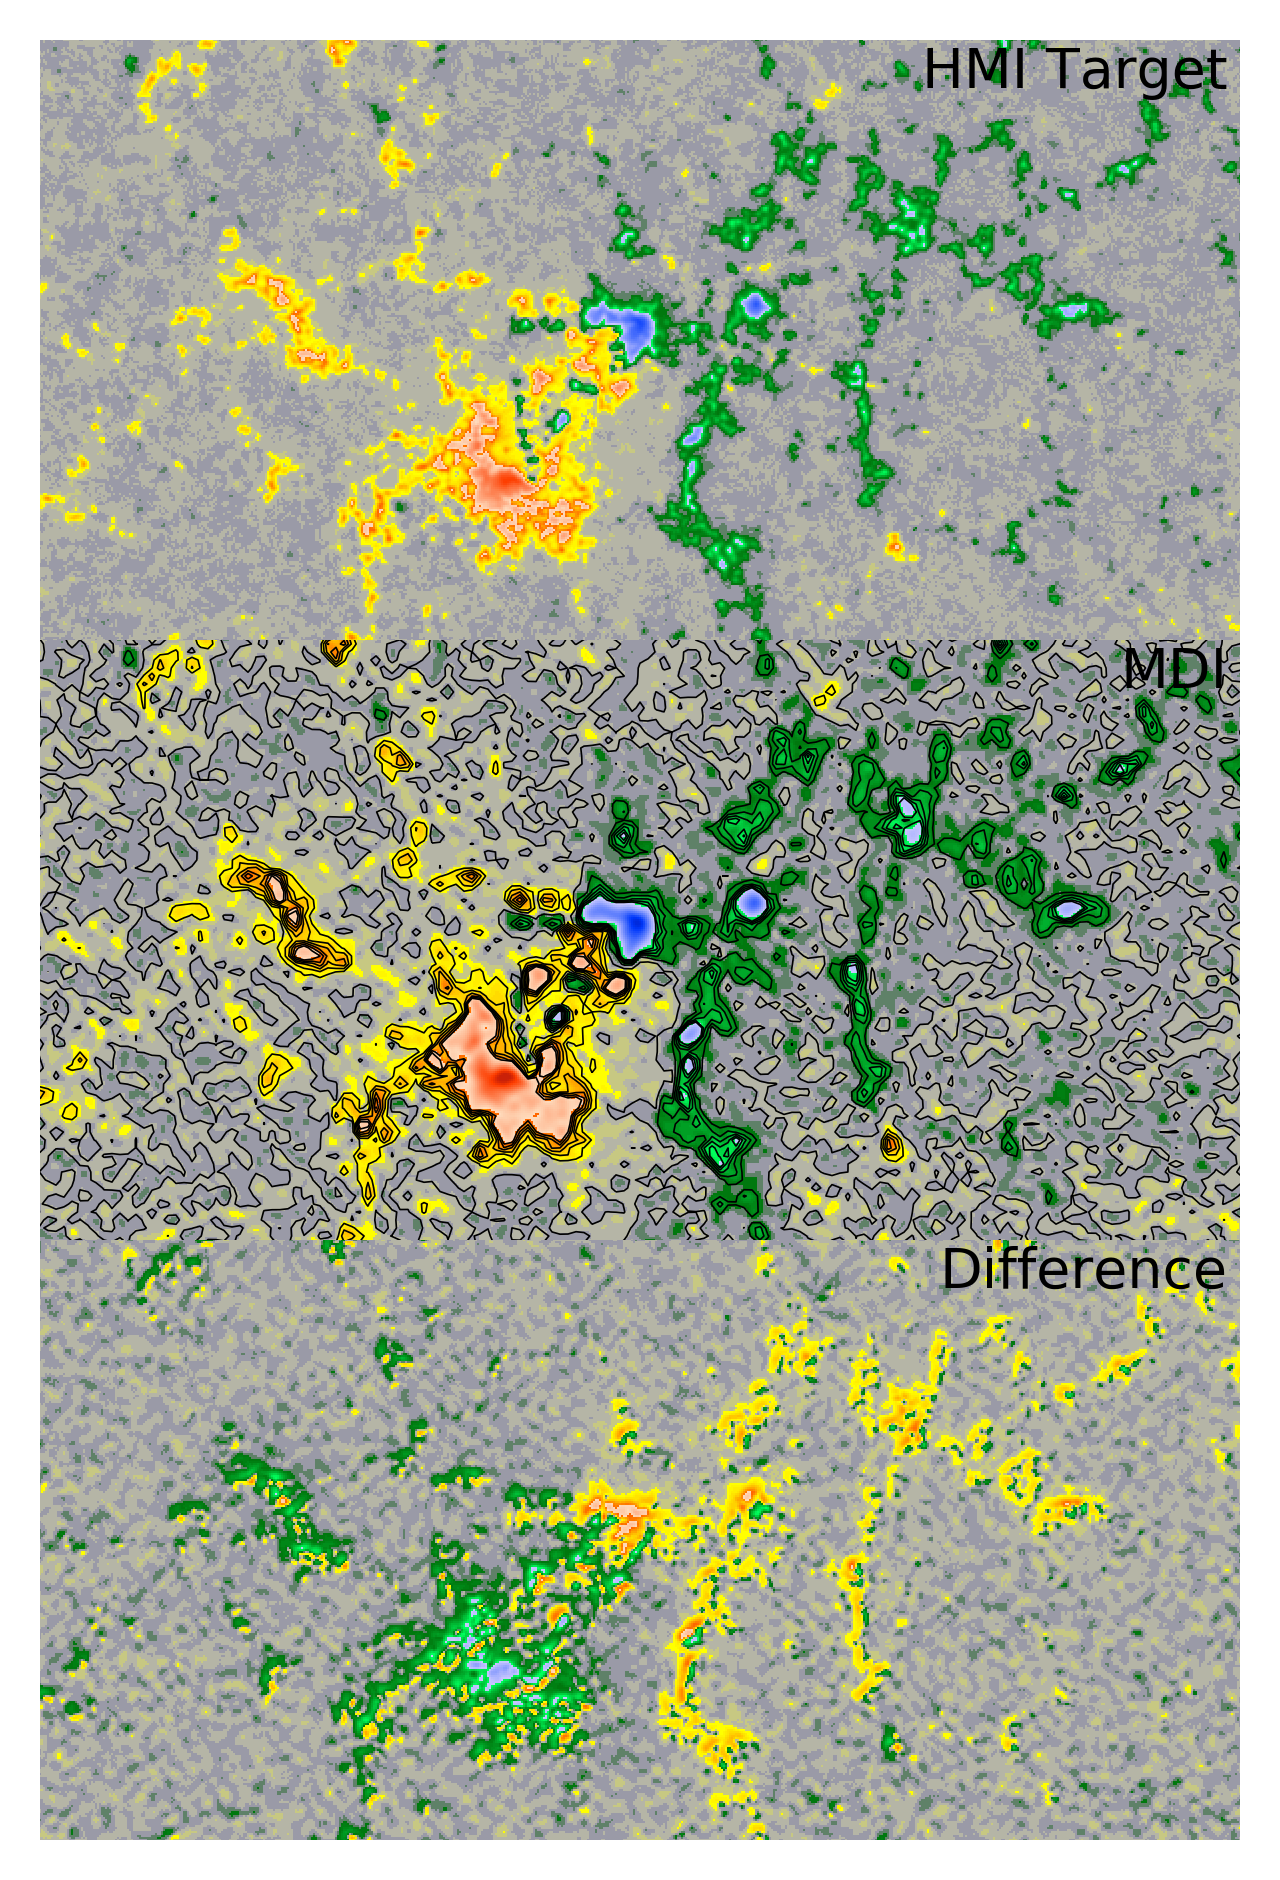

In [59]:
# Size definitions
dpi = 400
pxx = w_width*2   # Horizontal size of each panel
pxy = w_height*2   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Inferred
ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy])
ax1.imshow(MDImap.data, vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')

x, y = np.meshgrid(*[np.arange(v.value) for v in MDImapLR.dimensions])
ax1.contour(x*scale_factor+1, y*scale_factor+1, MDImapLR.data, np.arange(-300,300,50), colors='k', linestyles='-', linewidths=0.3)


ax1.set_axis_off()
ax1.text(0.99, 0.99, source, horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes)
ax1.set_xlim([indices[0]-w_width//2, indices[0]+w_width//2])
ax1.set_ylim([indices[0]-w_height//2, indices[0]+w_height//2])


ax2 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy])
ax2.imshow(mdi_hmi_map.data, vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax2.set_axis_off()
ax2.text(0.99, 0.99, 'HMI Target', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax2.transAxes)
ax2.set_xlim([indices[0]-w_width//2, indices[0]+w_width//2])
ax2.set_ylim([indices[0]-w_height//2, indices[0]+w_height//2])


ax3 = fig.add_axes([ppadh, ppadv-ppxy, ppxx, ppxy])
ax3.imshow(mdi_hmi_map.data-MDImap.data, vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax3.set_axis_off()
ax3.text(0.99, 0.99, 'Difference', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax3.transAxes)
ax3.set_xlim([indices[0]-w_width//2, indices[0]+w_width//2])
ax3.set_ylim([indices[0]-w_height//2, indices[0]+w_height//2])

# fig.savefig(label + '_FD.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

In [17]:
output_lr, footprint = reproject_interp(hr_map, hmi_map.wcs, np.array([1024, 1024]))
hr_hmi_map_lr = Map(output_lr, hmi_map.wcs)

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
/opt/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/opt/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/opt/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/opt/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/opt/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid 

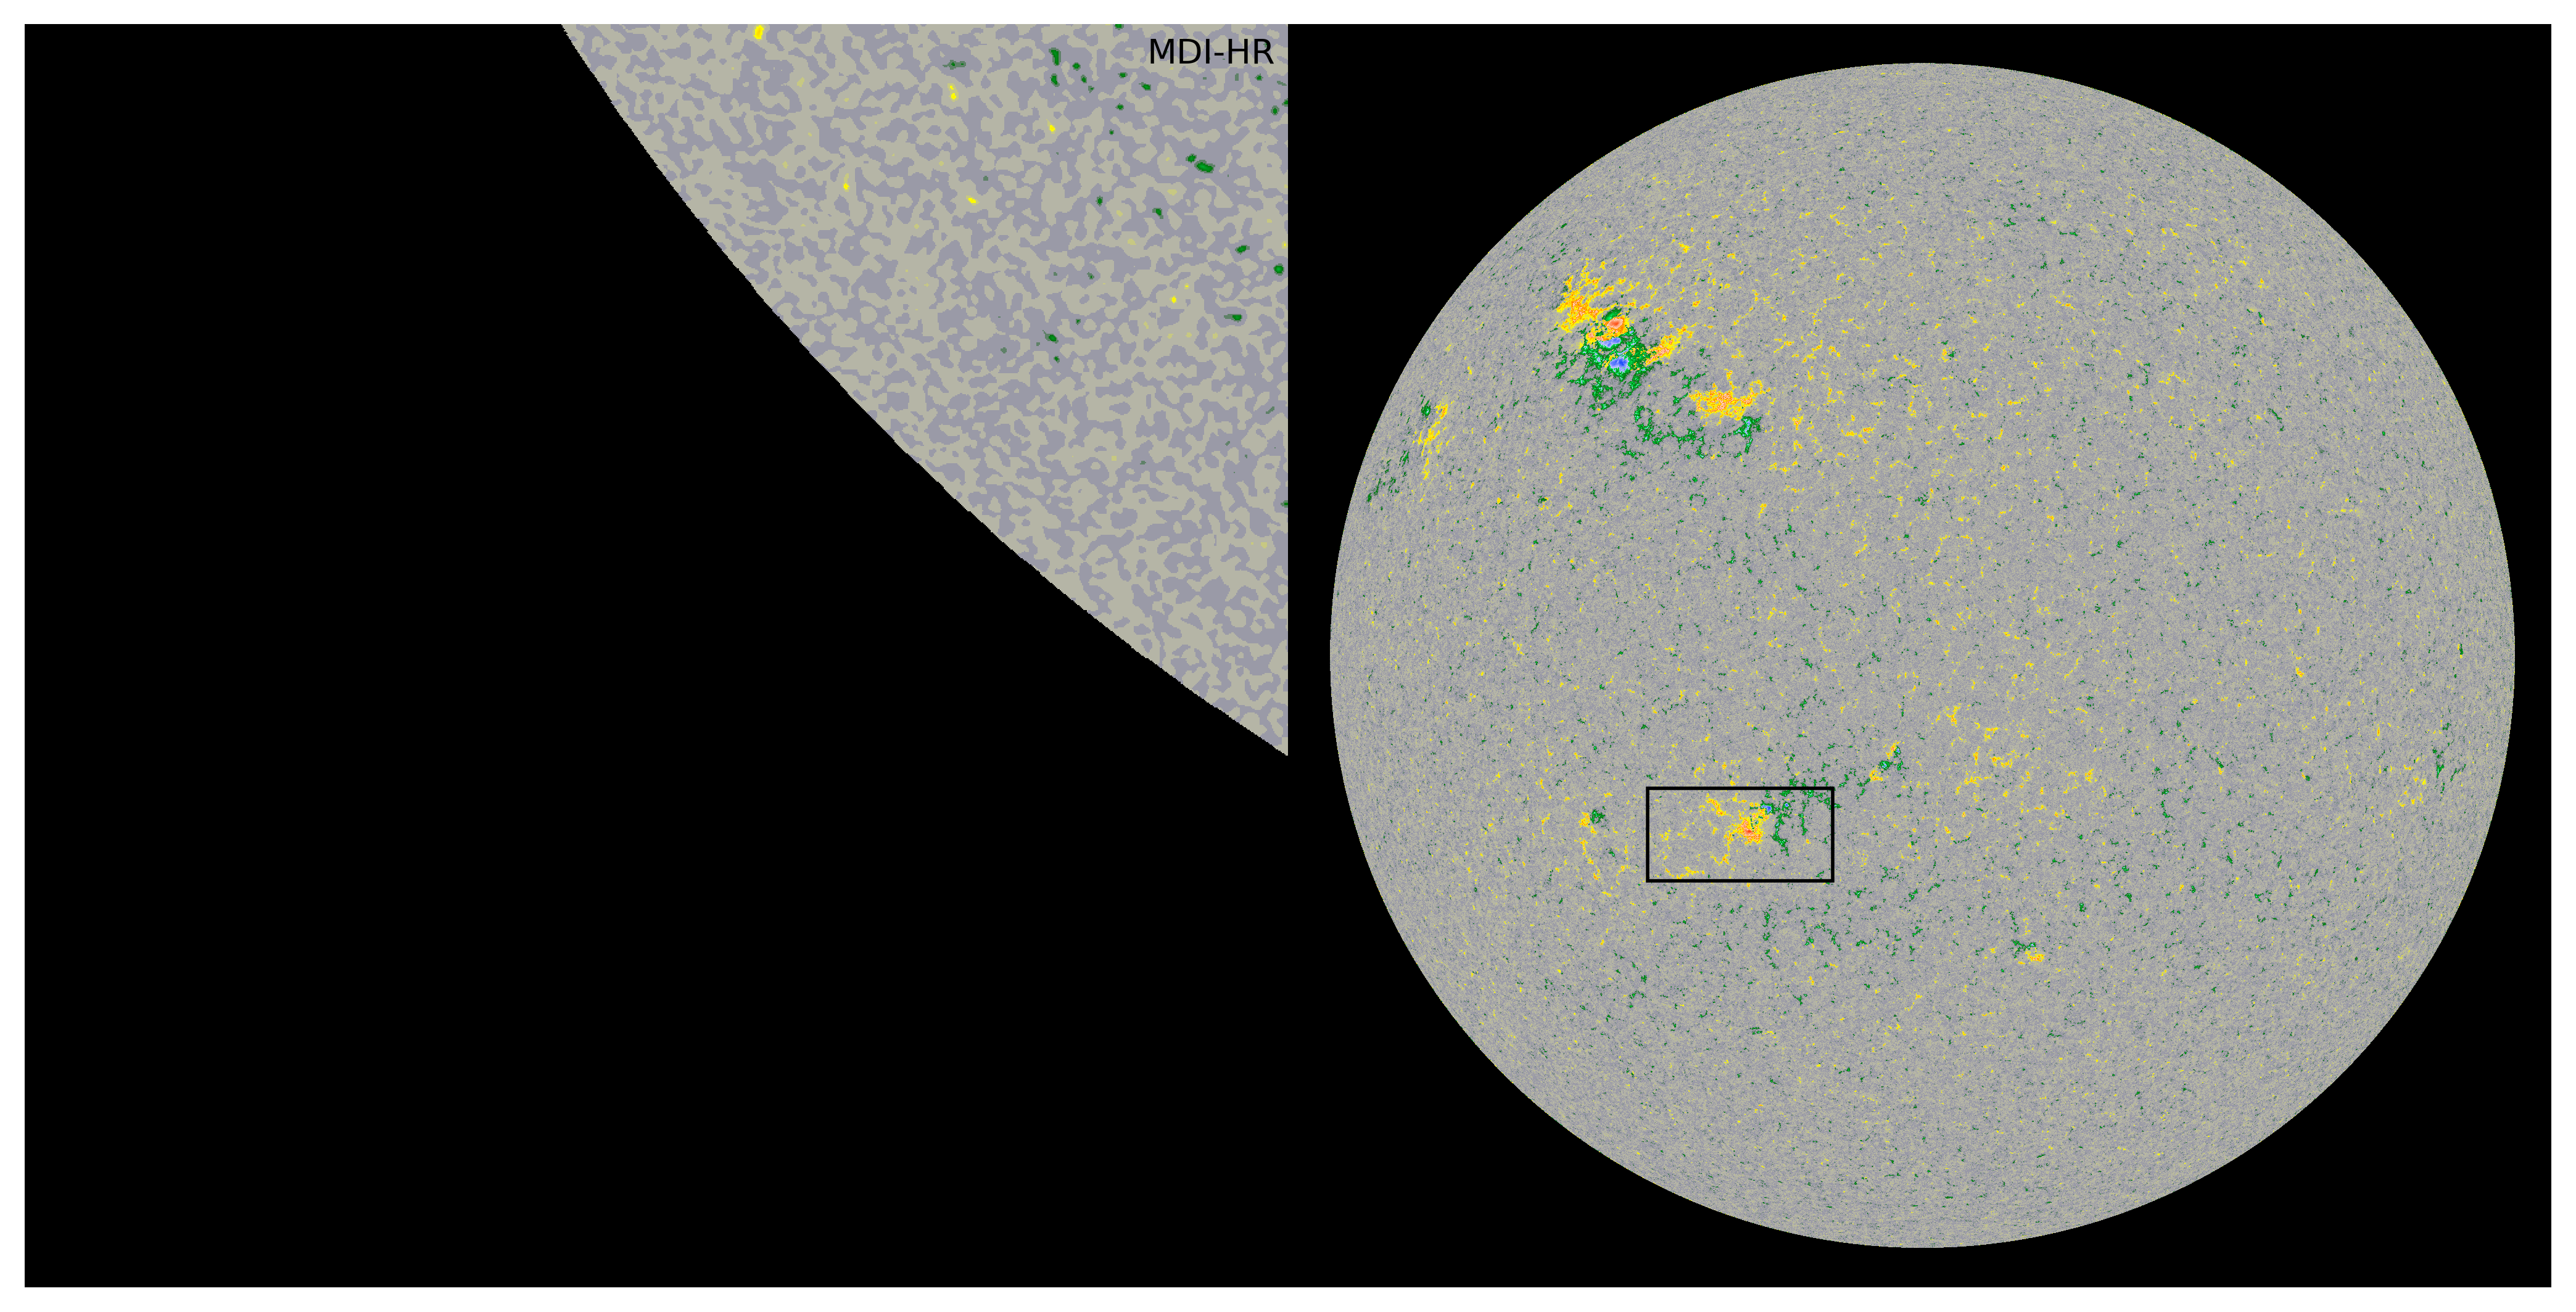

In [19]:
# Size definitions
dpi = 400
pxx = 4096/2   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 2     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Inferred
ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy])
ax1.imshow(hr_hmi_map_lr.data, vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax1.set_axis_off()
ax1.text(0.99, 0.99, source + '-HR', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes)
# ax1.fill([indices[0]-w_width//2, indices[0]-w_width//2, indices[0]+w_width//2, indices[0]+w_width//2], [indices[1]-w_height//2, indices[1]+w_height//2, indices[1]+w_height//2, indices[1]-w_height//2] , fc='None', ec='k')


ax2 = fig.add_axes([ppadh+ppxx, ppadv, ppxx, ppxy])
ax2.imshow(hmi_map.data, vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax2.set_axis_off()
ax2.text(0.99, 0.99, 'HMI Target', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax2.transAxes)
ax2.fill([indices[0]-w_width//2, indices[0]-w_width//2, indices[0]+w_width//2, indices[0]+w_width//2], [indices[1]-w_height//2, indices[1]+w_height//2, indices[1]+w_height//2, indices[1]-w_height//2] , fc='None', ec='k')

# fig.savefig(label + '_FD.png', bbox_inches='tight', dpi = dpi, pad_inches=0)